# Converting XML files to CSV 

In [1]:
import pandas as pd
from xml.etree import cElementTree as ElementTree
import xml.etree.ElementTree as et
from tqdm import tqdm
import logging
import re

logging.basicConfig(format='%(asctime)s: %(message)s', filename='analysis.log', level=logging.DEBUG)

## Convert XML files to Python Dictionaries 

In [2]:
class XmlListConfig(list):
    def __init__(self, aList):
        for element in aList:
            if element:
                # treat like dict
                if len(element) == 1 or element[0].tag != element[1].tag:
                    self.append(XmlDictConfig(element))
                # treat like list
                elif element[0].tag == element[1].tag:
                    self.append(XmlListConfig(element))
            elif element.text:
                text = element.text.strip()
                if text:
                    self.append(text)


class XmlDictConfig(dict):
    '''
    Example usage:

    >>> tree = ElementTree.parse('your_file.xml')
    >>> root = tree.getroot()
    >>> xmldict = XmlDictConfig(root)

    Or, if you want to use an XML string:

    >>> root = ElementTree.XML(xml_string)
    >>> xmldict = XmlDictConfig(root)

    And then use xmldict for what it is... a dict.
    '''
    def __init__(self, parent_element):
        if parent_element.items():
            self.update(dict(parent_element.items()))
        for element in parent_element:
            if element:
                # treat like dict - we assume that if the first two tags
                # in a series are different, then they are all different.
                if len(element) == 1 or element[0].tag != element[1].tag:
                    aDict = XmlDictConfig(element)
                # treat like list - we assume that if the first two tags
                # in a series are the same, then the rest are the same.
                else:
                    # here, we put the list in dictionary; the key is the
                    # tag name the list elements all share in common, and
                    # the value is the list itself 
                    aDict = {element[0].tag: XmlListConfig(element)}
                # if the tag has attributes, add those to the dict
                if element.items():
                    aDict.update(dict(element.items()))
                self.update({element.tag: aDict})
            # this assumes that if you've got an attribute in a tag,
            # you won't be having any text. This may or may not be a 
            # good idea -- time will tell. It works for the way we are
            # currently doing XML configuration files...
            elif element.items():
                self.update({element.tag: dict(element.items())})
            # finally, if there are no child tags and no attributes, extract
            # the text
            else:
                self.update({element.tag: element.text})

def get_field(xmldict, path=None, default=None):
    if path is None: return xmldict
    try:
        for p in path:
            # Ugly namespaces are ugly, let's deal with them here
            xmldict = xmldict['{http://www.irs.gov/efile}' + p]
        return xmldict
    except KeyError:
        # If this key does not exist in the dictionary, 
        return default
        # Note: it may be faster to check ```if p not in dict``` rather
        # than set up this try/except block. I think it depends on how
        # often this fails - the more it fails, the worse the try/except does.

In [5]:
tree = et.parse('data/test/201722789349300037_public.xml')
root = tree.getroot()
root

<Element '{http://www.irs.gov/efile}Return' at 0x000002660A022630>

## Analysis

### Analyze one file

This function returns a `1 x n` DataFrame of all relevant data for a single file, which can be appended to a larger DataFrame for multi-file analysis.

In [3]:
def analyze_one(path):
    object_id = re.sub("\D", "", path)
    object_list = [[object_id]]
    object_df = pd.DataFrame(object_list, columns =['Object_ID'])
    tree = et.parse(path)
    root = tree.getroot()
    #Converting from xml to dictionary
    xmldict = XmlDictConfig(root)

    
    ##############Header Information 
    #Date Information
    tax_period_begin = get_field(xmldict, ['ReturnHeader','TaxPeriodBeginDt'])
    
    #Filer Information
    filer_data = get_field(xmldict, ['ReturnHeader', 'Filer'], {})
    ein = get_field(filer_data, ['EIN'])
    business_name = get_field(filer_data, ['BusinessName', 'BusinessNameLine1Txt'])
    city = get_field(filer_data, ['USAddress', 'CityNm'])
    state = get_field(filer_data, ['USAddress', 'StateAbbreviationCd'])
    zipc = get_field(filer_data, ['USAddress', 'ZIPCd'])
    tax_year = get_field(xmldict, ['ReturnHeader', 'TaxYr'])
    filer_list = [[tax_year, tax_period_begin, ein, business_name, city, state, zipc]]
    filer_df = pd.DataFrame(filer_list, columns = ['TaxYr','TaxPeriodBeginDt','EIN', 'BusinessName', 'City', 'State', 'ZIPCd']) 
    
    
    ##############Return Data
    return_data = get_field(xmldict, ['ReturnData', 'IRS990'])
    if return_data is None:
        logging.warning(f'Could not find Return Data for file: {path}')
        return None
    
    #Formation Year
    formation_year = get_field(return_data, ['FormationYr'], "NA")
    
    #State of legal domicile 
    legal_dom = get_field(return_data, ['LegalDomicileStateCd'], "NA")
    
    #Related Org
    related = get_field(return_data, ['RelatedOrganizationsAmt'], 0)

    #GovernmentGrantsAmt
    gov_grants = get_field(return_data, ['GovernmentGrantsAmt'], 0)

    #FederatedCampaignsAmt
    fed_camp = get_field(return_data, ['FederatedCampaignsAmt'], 0)

    #MembershipDuesAmt
    membership = get_field(return_data, ['MembershipDuesAmt'], 0)

    #FundraisingAmt
    fundraising = get_field(return_data, ['FundraisingAmt'], 0)
    
    #NoncashContributionsAmt
    NoncashContributionsAmt = get_field(return_data, ['NoncashContributionsAmt'], 0)
    
    #AllOtherContributionsAmt
    all_other = get_field(return_data, ['AllOtherContributionsAmt'], 0)

    #TotalContributionsAmt
    total_contri = get_field(return_data, ['TotalContributionsAmt'], 0)
    
    #TotalProgramServiceRevenueAmt
    program_service_rev = get_field(return_data, ['TotalProgramServiceRevenueAmt'], 0)
    
    #CYInvestmentIncomeAmt
    CY_investment_income = get_field(return_data, ['CYInvestmentIncomeAmt'], 0)
    
    #CYOtherRevenueAmt
    CYOtherRevenueAmt = get_field(return_data, ['CYOtherRevenueAmt'], 0)
    
    #CYTotalRevenueAmt
    CYTotalRevenueAmt = get_field(return_data, ['CYTotalRevenueAmt'], 0)
    
    #CYTotalExpensesAmt
    CYTotalExpensesAmt = get_field(return_data, ['CYTotalExpensesAmt'], 0)
    
    #CYRevenuesLessExpensesAmt
    CYRevenuesLessExpensesAmt = get_field(return_data, ['CYRevenuesLessExpensesAmt'], 0)
    
    #TotalAssetsEOYAmt
    TotalAssetsEOYAmt = get_field(return_data, ['TotalAssetsEOYAmt'], 0)
    
    #TotalLiabilitiesEOYAmt
    TotalLiabilitiesEOYAmt = get_field(return_data, ['TotalLiabilitiesEOYAmt'], 0)
    
    #NetAssetsOrFundBalancesEOYAmt
    NetAssetsOrFundBalancesEOYAmt = get_field(return_data, ['NetAssetsOrFundBalancesEOYAmt'], 0)

    #ActivityOrMissionDesc
    ActivityOrMissionDesc = get_field(return_data, ['ActivityOrMissionDesc'], "")
    
    #MissionDesc
    descri = get_field(return_data, ['MissionDesc'], "")

    #TypeOfOrganizationCorpInd
    corp_ind = get_field(return_data, ['TypeOfOrganizationCorpInd'], "NA")
    
    #Trust
    TypeOfOrganizationTrustInd = get_field(return_data, ['TypeOfOrganizationTrustInd'], "NA")
    
    #asso
    TypeOfOrganizationAssocInd = get_field(return_data, ['TypeOfOrganizationAssocInd'], "NA")
    
    #other
    TypeOfOrganizationOtherInd = get_field(return_data, ['TypeOfOrganizationOtherInd'], "NA")
    
    #SchoolOperatingInd
    SchoolOperatingInd = get_field(return_data, ['SchoolOperatingInd'], "NA")
    
    #OperateHospitalInd
    OperateHospitalInd = get_field(return_data, ['OperateHospitalInd'], "NA") #Sometimes has {'referenceDocumentId': 'IRS990ScheduleH'} for true 
    
    #AddressChangeInd
    AddressChangeInd = get_field(return_data, ['AddressChangeInd'], "")
    
    #InitialReturnInd
    InitialReturnInd = get_field(return_data, ['InitialReturnInd'], "")
    
    #AmendedReturnInd
    AmendedReturnInd = get_field(return_data, ['AmendedReturnInd'], "")
    
    #TerminateOperationsInd
    TerminateOperationsInd = get_field(return_data, ['TerminateOperationsInd'], "")
    
    #ScheduleO
    schedule0 = get_field(xmldict,['ReturnData','IRS990ScheduleO'], "none")
   


    return_list = [[formation_year, legal_dom, related, gov_grants,fed_camp,membership,fundraising, NoncashContributionsAmt,all_other, total_contri,
                          program_service_rev, CY_investment_income,CYOtherRevenueAmt, CYTotalRevenueAmt,CYTotalExpensesAmt,CYRevenuesLessExpensesAmt,
                          TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc, descri, corp_ind,
                        TypeOfOrganizationTrustInd, TypeOfOrganizationAssocInd, TypeOfOrganizationOtherInd, SchoolOperatingInd, OperateHospitalInd,
                         AddressChangeInd, InitialReturnInd,AmendedReturnInd,TerminateOperationsInd,schedule0]]
    
    return_df = pd.DataFrame(return_list, columns = ['FormationYr', 'LegalDomicileStateCd','RelatedOrganizationsAmt','GovernmentGrantsAmt',
                                                                 'FederatedCampaignsAmt','MembershipDuesAmt','FundraisingAmt','NoncashContributionsAmt',
                                                                 'AllOtherContributionsAmt','TotalContributionsAmt','TotalProgramServiceRevenueAmt','CYInvestmentIncomeAmt',
                                                                 'CYOtherRevenueAmt','CYTotalRevenueAmt','CYTotalExpensesAmt','CYRevenuesLessExpensesAmt','TotalAssetsEOYAmt',
                                                                 'TotalLiabilitiesEOYAmt','NetAssetsOrFundBalancesEOYAmt',
                                                                 'ActivityOrMissionDesc','MissionDesc','TypeOfOrganizationCorpInd','TypeOfOrganizationTrustInd','TypeOfOrganizationAssocInd',
                                                                 'TypeOfOrganizationOtherInd','SchoolOperatingInd',
                                                                 'OperateHospitalInd','AddressChangeInd', 'InitialReturnInd','AmendedReturnInd','TerminateOperationsInd', 'schedule0'])
    ##############Schedule O
    #scheduleodesc = get_field(xmldict, ['ReturnData','ScheduleO'])
    
    #FORM 990, PART VI, SECTION B, LINE 11B
    #Form 990, Part III, Line 1
    
    #Concatenating header information and contributions
    return pd.concat([object_df, filer_df, return_df], axis=1, ignore_index=False)
    

### Example Analysis


In [9]:
df = pd.DataFrame([])

one_row = analyze_one('C:/Users/Administrator/Desktop/irs_2017/201743569349100404_public.xml')
df = df.append(one_row) 
df

""


### Get a list of files to analyze
You can generate a full index at the path used below with `extract_eins.ipynb`, or just download [this one](https://www.dropbox.com/s/237lcs9dcmqzjug/full_index.csv?dl=0) and place it in a folder called `index`. 

In [5]:
index = pd.read_csv('index/full_index.csv')
files = 'data/' + index.loc[index['TAX_YEAR'] == 2016]['OBJECT_ID'].astype('str') + '_public.xml'
files

6          data/201731359349202698_public.xml
15         data/201800529349300205_public.xml
19         data/201721359349307007_public.xml
28         data/201701869349300730_public.xml
36         data/201702209349300965_public.xml
                          ...                
3261613    data/201741309349201189_public.xml
3261621    data/201713109349302626_public.xml
3261629    data/201703189349103250_public.xml
3261637    data/201841319349304634_public.xml
3261645    data/201733199349101418_public.xml
Name: OBJECT_ID, Length: 437222, dtype: object

If you do not have all of these files available, you can do the following:

1. Run `files.to_csv('index/2017.txt', header=False, index=False)` to get a list of all the files you need to download
2. Run this in powershell: `ForEach ($file in (Get-Content -Path "index/2017.txt")) {aws s3 cp ("s3://irs-form-990/"+$file) ("data/"+$file)}` 

Note: I'm not able to completely test this script without reinstalling aws so this hasn't been completely tested but it *should* work.


### Alternative using all the files in the directory 

In [5]:
#This is the method I used to get all the files in the directory

import os

'''
    For the given path, get the List of all files in the directory tree 
'''
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles


dirName = 'C:/Users/Administrator/Desktop/irs_2017';
files = getListOfFiles(dirName)






### Create the dataframe with selected fields

In [6]:
df = pd.concat([one_row for name in tqdm(files) if (one_row := analyze_one(name)) is not None])
df

100%|██████████| 428974/428974 [1:02:20<00:00, 114.68it/s]


,Object_ID,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,...,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,TerminateOperationsInd,schedule0
0,2017201700069349300000,2014,2014-01-01,208368409,THE FAMILY CENTER OF GAP INC,Gap,PA,17527,2007,PA,...,NA,NA,NA,false,false,X,,,false,{'{http://www.irs.gov/efile}SupplementalInform...
0,2017201700069349300005,2015,2015-07-01,710433583,FRIENDSHIP COMMUNITY CARE INC,RUSSELLVILLE,AR,72811,1975,AR,...,NA,NA,NA,false,false,,,,false,{'{http://www.irs.gov/efile}SupplementalInform...
0,2017201700069349300010,2015,2015-01-01,352420579,DETROIT HBCU NETWORK,Grosse Pointe,MI,48236,2013,MI,...,NA,NA,X,false,false,,X,,false,{'{http://www.irs.gov/efile}SupplementalInform...
0,2017201700069349300015,2015,2015-09-01,201597292,HOWELL BASKETBALL CLUB INC,FARMINGDALE,NJ,07727,2004,NJ,...,NA,NA,NA,false,false,,,,false,{'{http://www.irs.gov/efile}SupplementalInform...
0,2017201700069349300020,2015,2015-07-01,943121699,THE DAVIS STREET COMMUNITY CENTER,SAN LEANDRO,CA,94577,1990,CA,...,NA,NA,NA,false,false,,,,false,{'{http://www.irs.gov/efile}SupplementalInform...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017201743579349300104,2016,2016-07-01,580611310,National Mental Health Association Georg,Atlanta,GA,30329,1976,GA,...,NA,NA,NA,false,false,X,,,false,{'{http://www.irs.gov/efile}SupplementalInform...
0,2017201743579349300504,2016,2016-04-01,421238299,IOWA ELKS ASSOCIATION CHARITABLE,MUSCATINE,IA,52761,1983,IA,...,NA,NA,NA,false,false,,,,false,{'{http://www.irs.gov/efile}SupplementalInform...
0,2017201743609349300104,2015,2015-07-01,465684634,MT EDEN HS FRIENDS OF THE CHOIR,Hayward,CA,94542,2010,CA,...,NA,NA,NA,false,false,,,,false,{'{http://www.irs.gov/efile}SupplementalInform...
0,2017201743609349300404,2016,2016-09-01,223780975,LITTLE FLYERS ACADEMY INC,ATLANTIC CITY AIRPORT,NJ,08405,2000,NJ,...,NA,NA,NA,false,false,,,,false,{'{http://www.irs.gov/efile}SupplementalInform...


In [7]:
df.to_csv("C:/Users/Administrator/Desktop/Impact_Capital/data/2017_objects.csv")

## stop here to add each year in parallel

# Data Cleaning

In [3]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
pd.set_option('display.min_rows', 200)
df = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/interim/990_2017.csv")

#Fixing Types of Orgs 
df.loc[df['TypeOfOrganizationCorpInd'] != "X", 'TypeOfOrganizationCorpInd'] = 0
df.loc[df['TypeOfOrganizationCorpInd'] == "X", 'TypeOfOrganizationCorpInd'] = 1
df.loc[df['TypeOfOrganizationTrustInd'] != "X", 'TypeOfOrganizationTrustInd'] = 0
df.loc[df['TypeOfOrganizationTrustInd'] == "X", 'TypeOfOrganizationTrustInd'] = 1
df.loc[df['TypeOfOrganizationTrustInd'] != "X", 'TypeOfOrganizationTrustInd'] = 0
df.loc[df['TypeOfOrganizationTrustInd'] == "X", 'TypeOfOrganizationTrustInd'] = 1
df.loc[df['TypeOfOrganizationAssocInd'] != "X", 'TypeOfOrganizationAssocInd'] = 0
df.loc[df['TypeOfOrganizationAssocInd'] == "X", 'TypeOfOrganizationAssocInd'] = 1
df.loc[df['TypeOfOrganizationOtherInd'] != "X", 'TypeOfOrganizationOtherInd'] = 0
df.loc[df['TypeOfOrganizationOtherInd'] == "X", 'TypeOfOrganizationOtherInd'] = 1

#SchoolOperatingInd	OperateHospitalInd	AddressChangeInd	InitialReturnInd	AmendedReturnInd	TerminateOperationsInd
df[['SchoolOperatingInd', 'OperateHospitalInd','AddressChangeInd','InitialReturnInd', 'AmendedReturnInd','TerminateOperationsInd']] =df[['SchoolOperatingInd', 'OperateHospitalInd','AddressChangeInd','InitialReturnInd', 'AmendedReturnInd','TerminateOperationsInd']].fillna(0)

df.loc[df['SchoolOperatingInd'] == 'false', 'SchoolOperatingInd'] = 0
df.loc[df['OperateHospitalInd'] == 'false', 'OperateHospitalInd'] = 0
df.loc[df['AddressChangeInd'] == 'false', 'AddressChangeInd'] = 0
df.loc[df['InitialReturnInd'] == 'false', 'InitialReturnInd'] = 0
df.loc[df['AmendedReturnInd'] == 'false', 'AmendedReturnInd'] = 0
df.loc[df['TerminateOperationsInd'] == 'false', 'TerminateOperationsInd'] = 0

df.loc[df['SchoolOperatingInd'] == '0', 'SchoolOperatingInd'] = 0
df.loc[df['OperateHospitalInd'] == '0', 'OperateHospitalInd'] = 0
df.loc[df['AddressChangeInd'] == '0', 'AddressChangeInd'] = 0
df.loc[df['InitialReturnInd'] == '0', 'InitialReturnInd'] = 0
df.loc[df['AmendedReturnInd'] == '0', 'AmendedReturnInd'] = 0
df.loc[df['TerminateOperationsInd'] == '0', 'TerminateOperationsInd'] = 0

df.loc[df['SchoolOperatingInd'] != 0, 'SchoolOperatingInd'] = 1
df.loc[df['OperateHospitalInd'] != 0, 'OperateHospitalInd'] = 1
df.loc[df['AddressChangeInd'] != 0, 'AddressChangeInd'] = 1
df.loc[df['InitialReturnInd'] != 0, 'InitialReturnInd'] = 1
df.loc[df['AmendedReturnInd'] != 0, 'AmendedReturnInd'] = 1
df.loc[df['TerminateOperationsInd'] != 0, 'TerminateOperationsInd'] = 1

#Merging the descriptions 
#The majority of the descriptions are just duplicates, so I'm deleting the ones that are exaclty the same 
#df.ActivityOrMissionDesc= df.ActivityOrMissionDesc.str.lower()
#df.MissionDesc= df.MissionDesc.str.lower()
#df.loc[df['ActivityOrMissionDesc'] ==  df['MissionDesc'], 'MissionDesc'] = ""


df = df.drop(['Object_ID', 'Unnamed: 0', 'Unnamed: 0.1','MissionDesc'], axis=1)
df

,TaxYr,TaxPeriodBeginDt,EIN,BusinessName,City,State,ZIPCd,FormationYr,LegalDomicileStateCd,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,ActivityOrMissionDesc,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd,TerminateOperationsInd
0,2017,2017-01-01,471186799,LEDFORD PANTHER ATHLETIC ASSOC INC,THOMASVILLE,NC,27360.0,2015.0,NC,0,0,0,205,0,0,1200,1405,64754,0,6597,72756,64238,8518,30869,0,30869,HIGH SCHOOL ATHLETIC BOOSTER CLUB. PROVIDES VO...,1,0,0,0,0,0,0,0,0,0
1,2017,2017-01-01,200090779,FRIENDS OF THE LEEWARD COAST PUBLIC,KAPOLEI,HI,96707.0,2001.0,NaN,0,0,0,0,0,0,1233610,1233610,0,18,0,1233628,1005716,227912,910892,0,910892,EDUCATION,1,0,0,0,0,0,0,0,0,0
2,2017,2017-01-01,431817270,WINONA VOLUNTEER FIRE DEPARTMENT,WINONA,MO,65588.0,1930.0,MO,0,0,0,0,0,0,50,50,0,31163,0,31213,27682,3531,1096269,82643,1013626,FIGHTING FIRES/EMERGENCY ASSI,0,0,1,0,0,0,0,0,0,0
3,2017,2017-01-01,540943951,ANTIOCH RECREATION ASSOCIATION INC,SANDSTON,VA,23150.0,1995.0,VA,0,0,0,0,0,0,1551,1551,54283,4,21583,77421,81674,-4253,19520,3703,15817,PROVIDE A SAFE AND ENJOYABLE RECREATION FACILI...,1,0,0,0,0,0,0,0,0,0
4,2017,2017-01-01,356024706,GREATER LAFAYETTE KENNEL CLUB INC,Lafayette,IN,47903.0,1945.0,IN,0,0,0,2114,0,0,12337,14451,130129,27,0,144607,105828,38779,120732,0,120732,TO FURTHER THE ADVANCEMENT OF ALL BREEDS OF DO...,1,0,0,0,0,0,0,0,0,0
5,2017,2017-01-01,731611375,MUSTARD SEED DEVELOPMENT CORP,OKLAHOMA CITY,OK,73113.0,2001.0,OK,0,0,0,0,0,0,23019,23019,0,-1234,0,21785,37663,-15878,360121,0,360121,"TO SHARE GOD'S JOY, HOPE, HEALING, AND DESIRE ...",1,0,0,0,0,0,0,0,0,0
6,2017,2017-01-01,270990624,ROTARY KIWANIS CALDWELL STREET FAIR,CALDWELL,NJ,7006.0,2012.0,NJ,0,0,0,0,0,0,0,0,0,0,137647,137647,136206,1441,13193,0,13193,THE ROTARY CLUB OF THE CALDWELLS AND THE KIWAN...,1,0,0,0,0,0,0,0,0,0
7,2017,2017-01-01,416051132,FIRST LUTHERAN CHURCH FOUNDATION FERGUS FALLS,FERGUS FALLS,MN,565372527.0,1965.0,MN,0,0,0,0,0,0,16175,16175,0,62310,0,78485,36707,41778,1856278,0,1856278,PROVICE SUPPORT TO FIRST LUTHERAN CHURCH AND V...,1,0,0,0,0,0,0,0,0,0
8,2017,2017-01-01,582115464,GORMAN RURITAN CLUB 495,Durham,NC,27704.0,1965.0,NC,0,0,0,800,0,0,0,800,19654,0,4002,24456,17701,6755,116981,0,116981,COMMUNITY SERVICES,0,0,1,0,0,0,0,0,0,0
9,2017,2017-01-01,820151745,MUD LAKE WATER USERS INC,TERRETON,ID,83450.0,NaN,NaN,0,0,0,0,0,0,0,0,1770256,812,12285,1783353,1508282,275071,1569510,3676,1565834,MAINTAIN THE CANALS AND PROVIDE IRRIGATION WAT...,1,0,0,0,0,0,0,0,0,0


In [4]:
df.to_csv('C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/processed/990_clean.csv',index=False)

# Statistical Analysis 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
df = pd.read_csv("C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/data/processed/990_clean.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253143 entries, 0 to 253142
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   TaxYr                          253143 non-null  int64  
 1   TaxPeriodBeginDt               253143 non-null  object 
 2   EIN                            253143 non-null  int64  
 3   BusinessName                   253143 non-null  object 
 4   City                           252923 non-null  object 
 5   State                          252923 non-null  object 
 6   ZIPCd                          252923 non-null  float64
 7   FormationYr                    235751 non-null  float64
 8   LegalDomicileStateCd           240345 non-null  object 
 9   RelatedOrganizationsAmt        253143 non-null  int64  
 10  GovernmentGrantsAmt            253143 non-null  int64  
 11  FederatedCampaignsAmt          253143 non-null  int64  
 12  MembershipDuesAmt             

In [3]:
df['TerminateOperationsInd'].value_counts()


0    250781
1      2362
Name: TerminateOperationsInd, dtype: int64

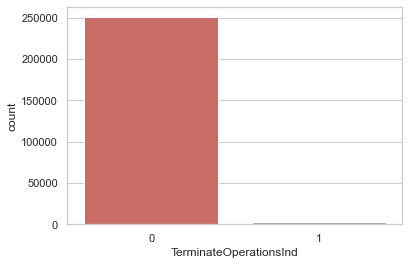

percentage of not terminating 99.06693054913626
percentage of termination 0.933069450863741


In [4]:
sns.countplot(x='TerminateOperationsInd', data = df, palette = 'hls')
plot = sns.countplot(x='TerminateOperationsInd', data = df, palette = 'hls')
figure = plot.get_figure() 
figure.savefig('C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/reports/terminate_countplot.png')
plt.show()

count_no_terminate = len(df[df['TerminateOperationsInd']==0])
count_terminate = len(df[df['TerminateOperationsInd']==1])
pct_of_no_terminate = count_no_terminate/(count_no_terminate+count_terminate)
print("percentage of not terminating", pct_of_no_terminate*100)
pct_of_terminate = count_terminate/(count_no_terminate+count_terminate)
print("percentage of termination", pct_of_terminate*100)

In [5]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
pd.set_option('display.min_rows', 200)

grouped = df.groupby('TerminateOperationsInd').mean()
grouped

,TaxYr,EIN,ZIPCd,FormationYr,RelatedOrganizationsAmt,GovernmentGrantsAmt,FederatedCampaignsAmt,MembershipDuesAmt,FundraisingAmt,NoncashContributionsAmt,AllOtherContributionsAmt,TotalContributionsAmt,TotalProgramServiceRevenueAmt,CYInvestmentIncomeAmt,CYOtherRevenueAmt,CYTotalRevenueAmt,CYTotalExpensesAmt,CYRevenuesLessExpensesAmt,TotalAssetsEOYAmt,TotalLiabilitiesEOYAmt,NetAssetsOrFundBalancesEOYAmt,TypeOfOrganizationCorpInd,TypeOfOrganizationTrustInd,TypeOfOrganizationAssocInd,TypeOfOrganizationOtherInd,SchoolOperatingInd,OperateHospitalInd,AddressChangeInd,InitialReturnInd,AmendedReturnInd
TerminateOperationsInd,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2017.0,4.628458e+08,5.509224e+07,1982.415080,142620.464369,682910.958179,8843.694231,43869.392370,39498.080680,261304.043684,991070.880928,1.908814e+06,7.672708e+06,5.167028e+05,235302.794965,1.033354e+07,9.621563e+06,7.119757e+05,2.272639e+07,9.945669e+06,1.278072e+07,0.887763,0.0,0.044003,0.022721,0.051619,0.009096,0.038436,0.009785,0.008398
1,2017.0,4.483790e+08,5.266077e+07,1989.336436,948233.414056,715338.838273,4129.345047,21057.866215,24961.882303,57341.964014,723813.883573,2.437535e+06,1.479850e+07,1.135805e+06,374693.948349,1.874654e+07,1.755093e+07,1.195606e+06,1.850976e+07,8.208012e+06,1.030175e+07,0.870872,0.0,0.030483,0.030483,0.140559,0.099915,0.117273,0.007197,0.008467


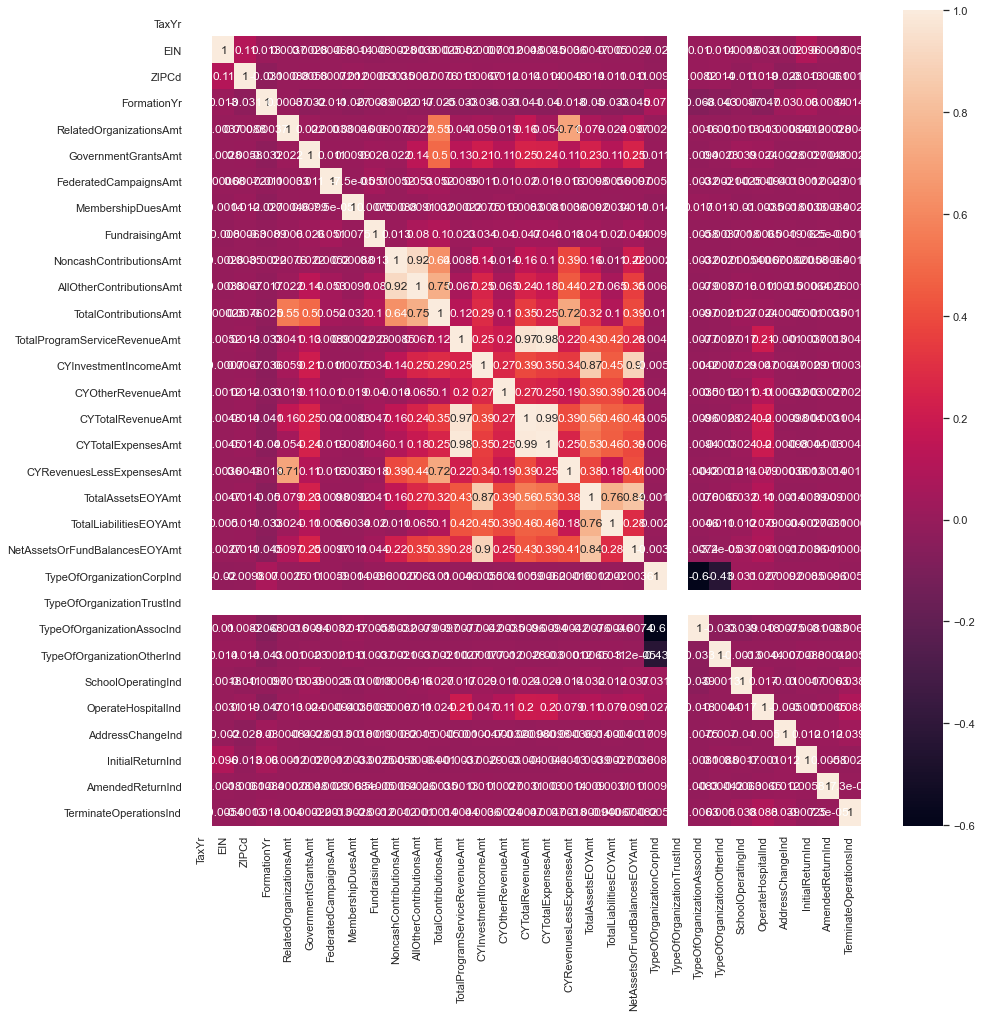

In [8]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)
plt.show()

## Observations from organizations that terminated operations:

* The average age of terminated organizations is 7 years older
* On average terminating organizations rely on related organization revenue 6.5 times as much 
* They rely more on grants 
* Receive half as much from federated campaigns (althoght his number is small in relative terms)
* Receive half as much on membership dues 
* Rely twice as much on programservice revenue 
* No noticeable difference in the type of organization
* Organizations that operate schools and hospitals more likely to terminate organizations

<Figure size 25200x10800 with 0 Axes>

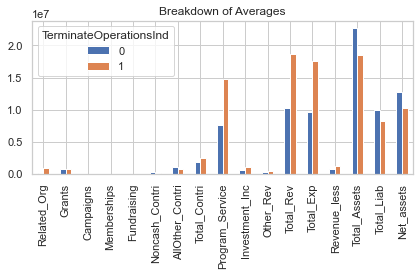

In [64]:
avg_plot = grouped.drop(['TaxYr', 'EIN', 'ZIPCd', 'FormationYr',
                       'TypeOfOrganizationCorpInd','TypeOfOrganizationTrustInd',
                       'TypeOfOrganizationAssocInd', 'TypeOfOrganizationOtherInd',
                       'AddressChangeInd', 'InitialReturnInd', 'AmendedReturnInd',
                        'SchoolOperatingInd', 'OperateHospitalInd'], axis = 1)
list(avg_plot.columns) 
avg_plot = avg_plot.rename(columns={'RelatedOrganizationsAmt' : 'Related_Org', 
                                     'GovernmentGrantsAmt': 'Grants',
                                     'FederatedCampaignsAmt' : 'Campaigns',
                                     'MembershipDuesAmt' : 'Memberships',
                                     'FundraisingAmt' : 'Fundraising',
                                     'NoncashContributionsAmt' : 'Noncash_Contri',
                                     'AllOtherContributionsAmt': 'AllOther_Contri',
                                     'TotalContributionsAmt' : 'Total_Contri',
                                     'TotalProgramServiceRevenueAmt' : 'Program_Service',
                                     'CYInvestmentIncomeAmt':'Investment_Inc',
                                     'CYOtherRevenueAmt' : 'Other_Rev',
                                     'CYTotalRevenueAmt': 'Total_Rev',
                                     'CYTotalExpensesAmt': 'Total_Exp',
                                     'CYRevenuesLessExpensesAmt':'Revenue_less' ,
                                     'TotalAssetsEOYAmt' : 'Total_Assets',
                                     'TotalLiabilitiesEOYAmt':'Total_Liab',
                                     'NetAssetsOrFundBalancesEOYAmt': 'Net_assets'})

# Transpose the columns and index 
avg_plotT = avg_plot.T

#
plt.figure(figsize=(350,150))
ax = avg_plotT.plot.bar(rot=0)
plt.title("Breakdown of Averages")
plt.xticks(rotation='vertical')
plt.tight_layout()
figure = ax.get_figure() 
figure.savefig('C:/Users/tenis/OneDrive/Desktop/Data_Projects/Impact_Capital/reports/average_breakdown.png', dpi = 150)

In [39]:
from sklearn import preprocessing

logistic = df.drop(['TaxYr',
                    'TaxPeriodBeginDt',
                    'EIN', 'BusinessName',
                    'City',
                    'State',
                    'ZIPCd',
                    'LegalDomicileStateCd',
                    'ActivityOrMissionDesc',
                    'CYRevenuesLessExpensesAmt',
                    'CYTotalRevenueAmt',
                    'TotalLiabilitiesEOYAmt',
                    'NetAssetsOrFundBalancesEOYAmt',
                    'TotalContributionsAmt',
                   'CYTotalExpensesAmt',
                    'TotalAssetsEOYAmt',
                   'TypeOfOrganizationTrustInd'], axis =1)

#Apparently no trust in this dataset. 
logistic = logistic.fillna(0)


X = logistic.loc[:, logistic.columns != 'TerminateOperationsInd']
X_colnames = X.columns
#normalizeing
X = preprocessing.normalize(X)
X = pd.DataFrame(X, columns = X_colnames)
y = logistic.loc[:, logistic.columns == 'TerminateOperationsInd']

#In order to over sample terminated nonprofits i'll be using SMOTE
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['TerminateOperationsInd'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of terminated nonprofits in oversampled data",len(os_data_y[os_data_y['TerminateOperationsInd']==1]))
print("Number of surviving nonprofits",len(os_data_y[os_data_y['TerminateOperationsInd']==0]))
print("Proportion of terminated nonprofit data in oversampled data is ",len(os_data_y[os_data_y['TerminateOperationsInd']==1])/len(os_data_X))
print("Proportion of surviving nonprofit data in oversampled data is ",len(os_data_y[os_data_y['TerminateOperationsInd']==0])/len(os_data_X))

length of oversampled data is  351150
Number of terminated nonprofits in oversampled data 175575
Number of surviving nonprofits 175575
Proportion of terminated nonprofit data in oversampled data is  0.5
Proportion of surviving nonprofit data in oversampled data is  0.5


In [40]:
#Recursive Feature Elimination
data_final_vars=logistic.columns.values.tolist()
y=['TerminateOperationsInd']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter = 1000)
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\Users\tenis\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [59]:
mask = rfe.support_
mask = mask.tolist()
mask.append(False)
cols = logistic.loc[:, mask]
#I had to select these variables to get it to work
cols = cols[['FormationYr', 'GovernmentGrantsAmt', 'TypeOfOrganizationCorpInd', 'TypeOfOrganizationAssocInd','TypeOfOrganizationOtherInd', 'SchoolOperatingInd']]
cols = cols.columns

In [61]:
X=os_data_X[cols]
y=os_data_y['TerminateOperationsInd']

In [62]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit(maxiter = 200)
print(result.summary2())

C:\Users\tenis\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 200


C:\Users\tenis\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix